In [1]:
from google.colab import files
upload=files.upload()

Saving ultimate_data_challenge.json to ultimate_data_challenge.json
Saving logins.json to logins.json


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
logins_df = pd.read_json('/content/logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
ultimate_df = pd.read_json('/content/ultimate_data_challenge.json')
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [5]:
print(logins_df.shape)
print(ultimate_df.shape)

(93142, 1)
(50000, 12)


# Data Wrangling

In [6]:
print(logins_df.info)
print('='*120, '\n',)
print(ultimate_df.info)

<bound method DataFrame.info of                login_time
0     1970-01-01 20:13:18
1     1970-01-01 20:16:10
2     1970-01-01 20:16:37
3     1970-01-01 20:16:36
4     1970-01-01 20:26:21
...                   ...
93137 1970-04-13 18:50:19
93138 1970-04-13 18:43:56
93139 1970-04-13 18:54:02
93140 1970-04-13 18:57:38
93141 1970-04-13 18:54:23

[93142 rows x 1 columns]>

<bound method DataFrame.info of                  city  trips_in_first_30_days signup_date  \
0      King's Landing                       4  2014-01-25   
1             Astapor                       0  2014-01-29   
2             Astapor                       3  2014-01-06   
3      King's Landing                       9  2014-01-10   
4          Winterfell                      14  2014-01-27   
...               ...                     ...         ...   
49995  King's Landing                       0  2014-01-25   
49996         Astapor                       1  2014-01-24   
49997      Winterfell                       0  

In [7]:
## add 1 for each row, it will help with aggregation
logins_df['counts'] = 1

In [8]:
logins_df.head()

,login_time,counts
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [9]:
# check for null values
logins_df['login_time'].isnull().sum()

0

In [10]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
 1   counts      93142 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.4 MB


In [11]:
# set_index is used to set a new index to the DataFrame
logins_df.set_index('login_time', inplace=True)

In [12]:
logins_df.head()

,counts
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


# Exploratory Data Analysis

In [13]:
# 15-min interval, Grouper organizes time in minutes/weeks/months
login_df_15min = logins_df.groupby(pd.Grouper(freq='15Min')).sum()
login_df_15min.head()

,counts
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [14]:
# Now reset the index
login_df_15min.reset_index()

,login_time,counts
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
...,...,...
9783,1970-04-13 17:45:00,5
9784,1970-04-13 18:00:00,5
9785,1970-04-13 18:15:00,2
9786,1970-04-13 18:30:00,7


Text(0, 0.5, 'Counts')

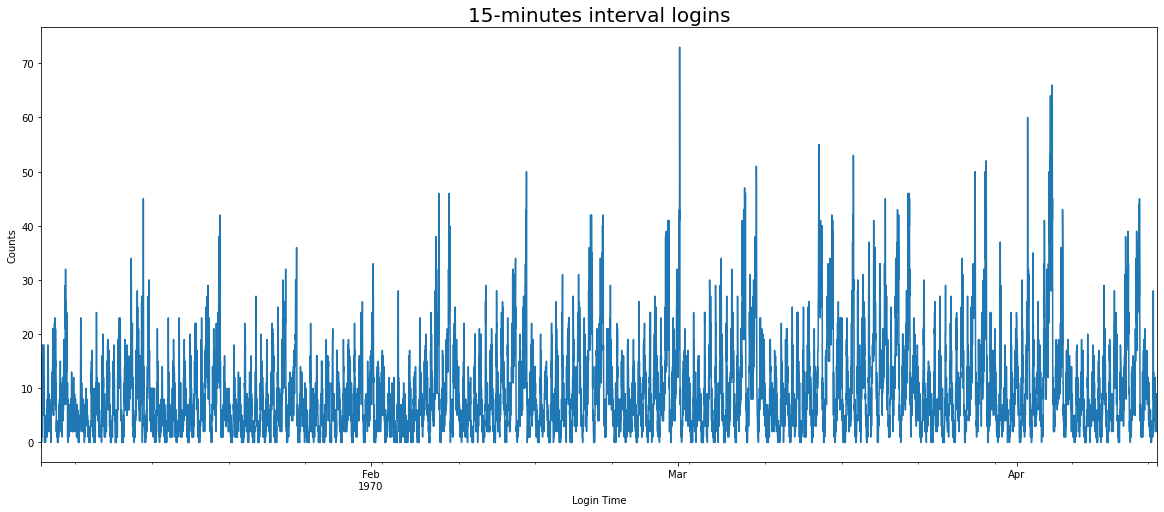

In [15]:
# Plot the 15-min time interval
plt.figure(figsize=(20,8))
login_df_15min['counts'].plot()
plt.title('15-minutes interval logins', size = 20)
plt.xlabel('Login Time')
plt.ylabel('Counts')

Plot above of 15-minutes time intervals doesn't shows much information so let's try other intervals and see if we can find some more details.

In [16]:
# 24-hour interval, Grouper organizes time in minutes/weeks/months
login_df_24hour = logins_df.groupby(pd.Grouper(freq='24H')).sum()
login_df_24hour.head()

,counts
login_time,
1970-01-01,112
1970-01-02,681
1970-01-03,793
1970-01-04,788
1970-01-05,459


In [17]:
# Now reset the index
login_df_24hour.reset_index()

,login_time,counts
0,1970-01-01,112
1,1970-01-02,681
2,1970-01-03,793
3,1970-01-04,788
4,1970-01-05,459
...,...,...
98,1970-04-09,818
99,1970-04-10,1009
100,1970-04-11,1352
101,1970-04-12,1409


Text(0, 0.5, 'Counts')

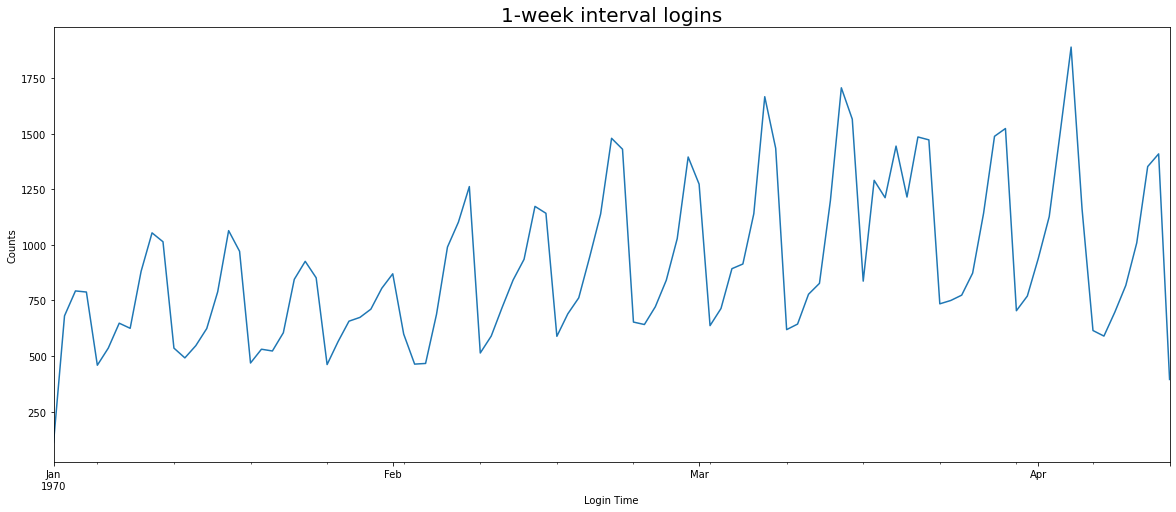

In [18]:
# Plot the 24-hour time interval
plt.figure(figsize=(20,8))
login_df_24hour['counts'].plot()
plt.title('1-week interval logins', size = 20)
plt.xlabel('Login Time')
plt.ylabel('Counts')

In [19]:
# 1-week interval, Grouper organizes time in minutes/weeks/months
login_df_1week = logins_df.groupby(pd.Grouper(freq='1W')).sum()
login_df_1week.head()

,counts
login_time,
1970-01-04,2374
1970-01-11,5217
1970-01-18,5023
1970-01-25,4751
1970-02-01,4744


In [20]:
# Now reset the index
login_df_1week.reset_index()

,login_time,counts
0,1970-01-04,2374
1,1970-01-11,5217
2,1970-01-18,5023
3,1970-01-25,4751
4,1970-02-01,4744
5,1970-02-08,5572
6,1970-02-15,5915
7,1970-02-22,7035
8,1970-03-01,6554
9,1970-03-08,7398


Text(0, 0.5, 'Counts')

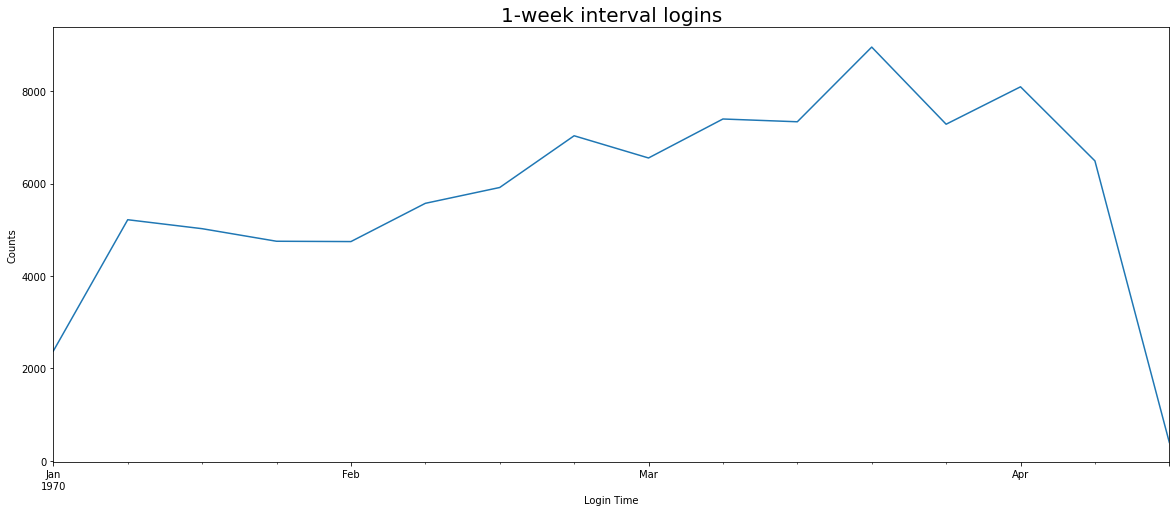

In [21]:
# Plot the 1-week time interval
plt.figure(figsize=(20,8))
login_df_1week['counts'].plot()
plt.title('1-week interval logins', size = 20)
plt.xlabel('Login Time')
plt.ylabel('Counts')

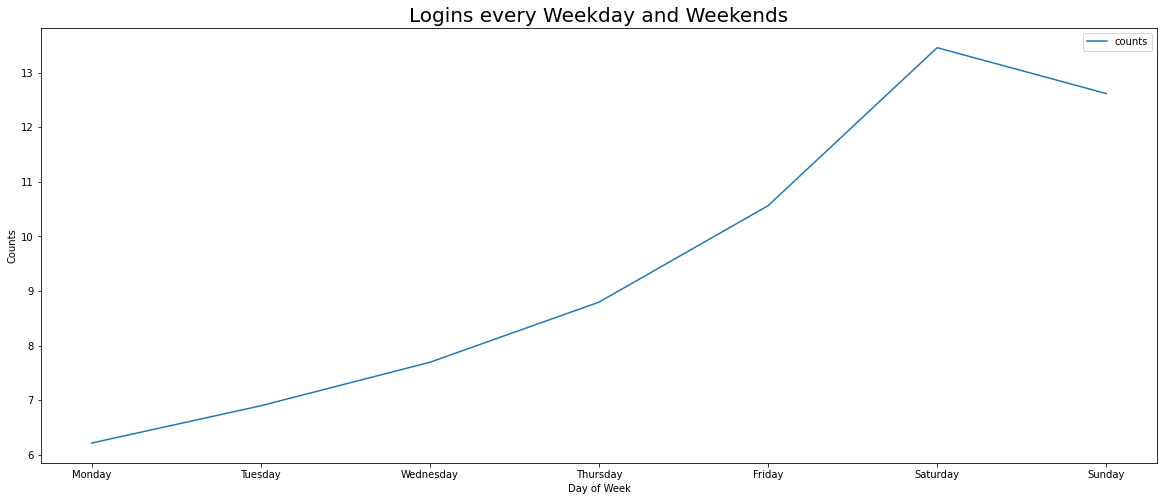

In [22]:
# Every weekday and weekend login traffic
counts_df_wd = login_df_15min.groupby(pd.Grouper(freq="15min")).sum()
lgwd = counts_df_wd.groupby(counts_df_wd.index.weekday).mean()
counts_df_wd.groupby(counts_df_wd.index.weekday)
#lgwd.plot()
#plt.figure(lgwd, figsize=(20,8))
#lgwd.plot()
fig, ax = plt.subplots(figsize=(20,8))
lgwd.plot(ax=ax)

plt.title('Logins every Weekday and Weekends', size = 20)
plt.xlabel('Day of Week')
plt.ylabel('Counts')
plt.xticks(ticks=range(len(lgwd)), labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]);

In [23]:
# 1-month interval, Grouper organizes time in minutes/weeks/months
login_df_1month = logins_df.groupby(pd.Grouper(freq='1M')).sum()
login_df_1month.head()

,counts
login_time,
1970-01-31,21239
1970-02-28,24673
1970-03-31,33723
1970-04-30,13507


In [24]:
# Now reset the index
login_df_1month.reset_index()

,login_time,counts
0,1970-01-31,21239
1,1970-02-28,24673
2,1970-03-31,33723
3,1970-04-30,13507


Text(0, 0.5, 'Counts')

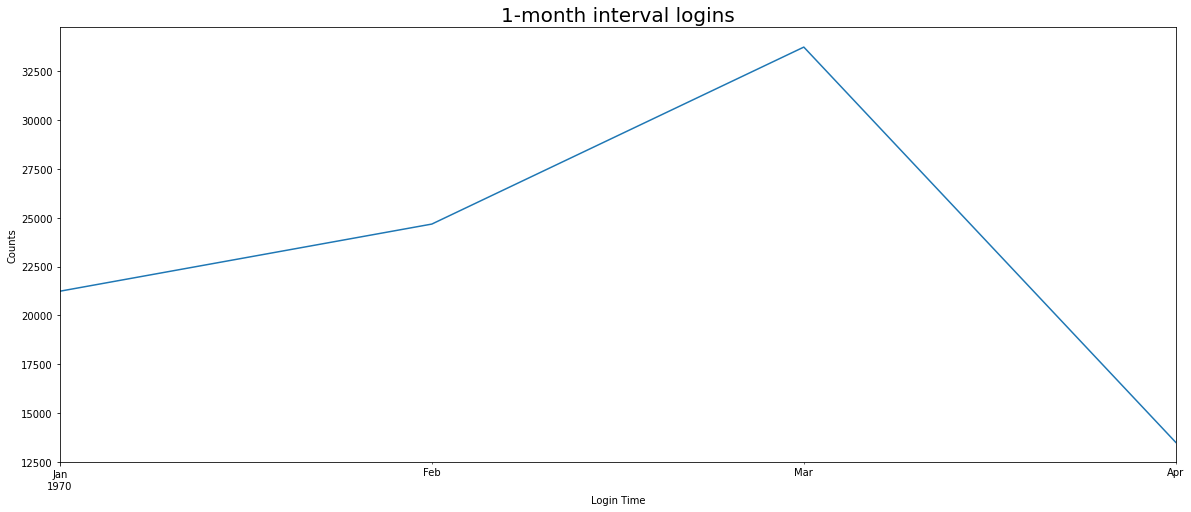

In [25]:
# Plot the 1-month time interval
plt.figure(figsize=(20,8))
login_df_1month['counts'].plot()
plt.title('1-month interval logins', size = 20)
plt.xlabel('Login Time')
plt.ylabel('Counts')

The above chart depicts the amount of 'logins' per month. Above, we can see a steady increase in the amount of log ins from January to March. Followed by a sharp decrease leading into the month of April. The increase from Jan to Mar could be seasonal and due to colder temperatures. As the weather begins to increase people are more likely to walk or take public transportation.  

In [26]:
# Chekc for null values in ultimate file
ultimate_df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [27]:
ultimate_df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [28]:
print(ultimate_df.avg_rating_of_driver.median())
print(ultimate_df.avg_rating_by_driver.median())

4.9
5.0


In [29]:
# filling in missing values, both distributions below are left skewed will use median

arod_med = ultimate_df['avg_rating_of_driver'].median()
ultimate_df['avg_rating_of_driver'].fillna(arod_med, inplace=True)

arbd_med = ultimate_df['avg_rating_by_driver'].median()
ultimate_df['avg_rating_by_driver'].fillna(arbd_med, inplace=True)

ultimate_df['phone'].fillna('Unknown', inplace=True)

In [30]:
arod_med, arbd_med

(4.9, 5.0)

In [31]:
ultimate_df.head(1)

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.1,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0


In [32]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    50000 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   50000 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    50000 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [33]:
## Change datatype, convert dates from object to datetime columns
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])

In [34]:
ultimate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [35]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Feature Engineering
Let's add another column as retained based on the `last_trip_date`.

In [36]:
# New column based on 'last_trip_date', potential target column? Retained vs not_retained
ultimate_df['retained'] = np.where(ultimate_df['last_trip_date'] > '2014-06-01', 'retained', 'not_retained')
ultimate_df['retained'].head()

0        retained
1    not_retained
2    not_retained
3        retained
4    not_retained
Name: retained, dtype: object

In [37]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,retained
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not_retained
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not_retained
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,retained
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not_retained


In [38]:
# Find percentage of customers retained
print(ultimate_df['retained'].value_counts())

not_retained    31690
retained        18310
Name: retained, dtype: int64


In [39]:
percent_retained = (18310/31690) * 100
print("Percentage of customers retained: {:.0f}%".format(percent_retained))

Percentage of customers retained: 58%


Text(0.5, 1.0, 'No of Users per city')

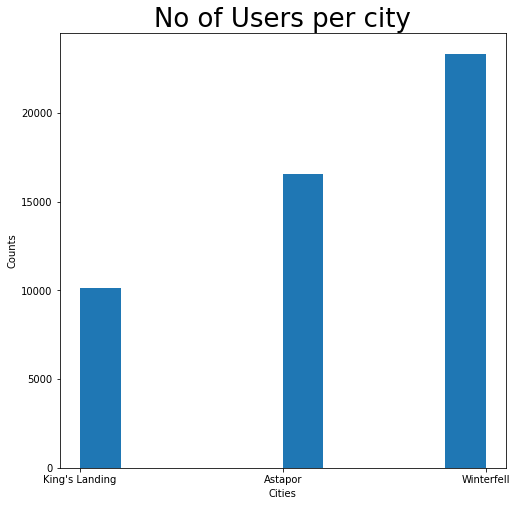

In [40]:
plt.figure(figsize=(8,8))
plt.hist(ultimate_df['city'])
plt.xlabel('Cities')
plt.ylabel('Counts')
plt.title('No of Users per city', size = 26)

Text(0.5, 1.0, 'Customer Phone Types')

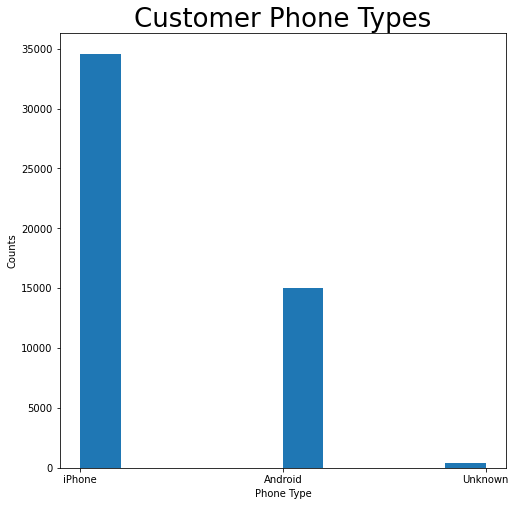

In [41]:
plt.figure(figsize=(8,8))
plt.hist(ultimate_df['phone'])
plt.xlabel('Phone Type')
plt.ylabel('Counts')
plt.title('Customer Phone Types', size = 26)

Text(0.5, 1.0, 'Average rating of driver')

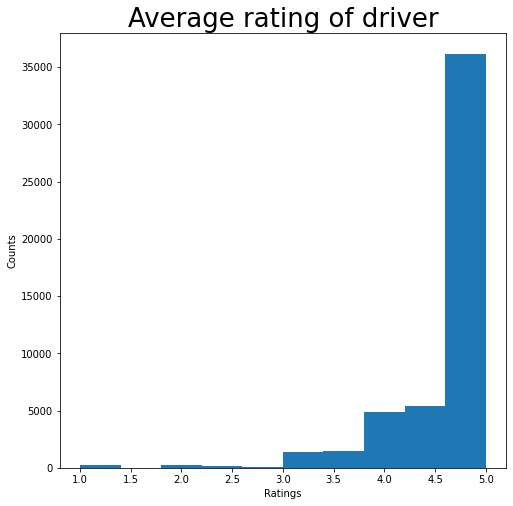

In [42]:
plt.figure(figsize=(8,8))
plt.hist(ultimate_df['avg_rating_of_driver'])
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Average rating of driver', size = 26)

Text(0.5, 1.0, 'Average rating by driver')

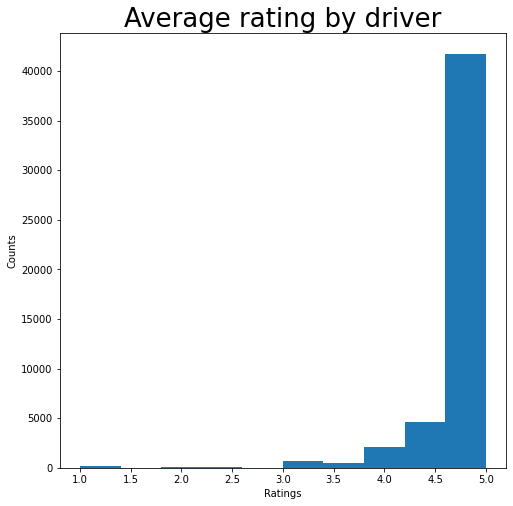

In [43]:
plt.figure(figsize=(8,8))
plt.hist(ultimate_df['avg_rating_by_driver'])
plt.xlabel('Ratings')
plt.ylabel('Counts')
plt.title('Average rating by driver', size = 26)

Text(0, 0.5, 'Counts')

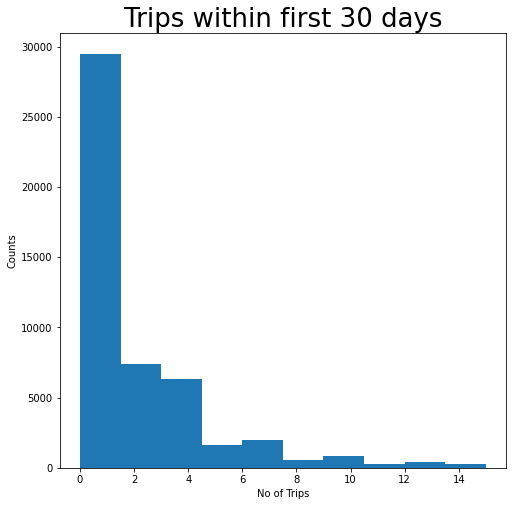

In [44]:
plt.figure(figsize=(8,8))
plt.hist(ultimate_df['trips_in_first_30_days'], range=(0,15))
plt.title('Trips within first 30 days', size = 26)
plt.xlabel('No of Trips')
plt.ylabel('Counts')

# Machine Learning Model

In [45]:
# Convert signup dates to seperate columns of day, month and year 
ultimate_df['signup_day'] = ultimate_df['signup_date'].dt.day
ultimate_df['signup_month'] = ultimate_df['signup_date'].dt.month
ultimate_df['signup_year'] = ultimate_df['signup_date'].dt.year

In [46]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day,signup_month,signup_year
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,retained,25,1,2014
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not_retained,29,1,2014
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not_retained,6,1,2014
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,retained,10,1,2014
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not_retained,27,1,2014


In [47]:
# Convert last trip dates to seperate columns of day, month and year
ultimate_df['last_day'] = ultimate_df['last_trip_date'].dt.day
ultimate_df['last_month'] = ultimate_df['last_trip_date'].dt.month
ultimate_df['last_year'] = ultimate_df['last_trip_date'].dt.year

In [48]:
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,signup_day,signup_month,signup_year,last_day,last_month,last_year
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,retained,25,1,2014,17,6,2014
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,not_retained,29,1,2014,5,5,2014
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,not_retained,6,1,2014,7,1,2014
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,retained,10,1,2014,29,6,2014
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,not_retained,27,1,2014,15,3,2014


In [50]:
# Drop the unnecessary columns
#ultimate_df.drop(columns=['retained', 'signup_date', 'last_trip_date']).head()
x1 = ultimate_df.drop(columns=['retained', 'signup_date', 'last_trip_date'])

In [51]:
x1.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_day,signup_month,signup_year,last_day,last_month,last_year
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,25,1,2014,17,6,2014
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,29,1,2014,5,5,2014
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,6,1,2014,7,1,2014
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,10,1,2014,29,6,2014
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,27,1,2014,15,3,2014


## Extraction and feature selection
Let's extract the features, split them into the train, and test for model building.

In [54]:
X = pd.get_dummies(x1, drop_first=True)
y = ultimate_df['retained']

In [55]:
X.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,signup_day,signup_month,signup_year,last_day,last_month,last_year,city_King's Landing,city_Winterfell,phone_Unknown,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,25,1,2014,17,6,2014,1,0,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,29,1,2014,5,5,2014,0,0,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,6,1,2014,7,1,2014,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,10,1,2014,29,6,2014,1,0,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,27,1,2014,15,3,2014,0,1,0,0


## Train-Test Split

In [56]:
# splitting the training data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.3, random_state=42)

std = StandardScaler()

X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

# Experiment and metrics design

1. The goal of this experiment is to increase driver availability across both cities. As a key measure of success for encouraging drivers to be available in both cities I will measure the amount of tolls crossed. 
2. This experiment will be implemented in the following ways, first the drivers will be split into two groups A and B. Group A consist of drivers and users who crossed the toll frequently, let's say 50-times a week, and Group B consist of drivers and users who crossed the toll less than 50-times per week. I will implement no toll for both groups on the slow hours or days so that both drivers and users could get max benefit by encouraged to travel on slow days which will help to minimize the traffic and congession issue. This experiment will last for 1-month.
For the next whole month, everyone who crossed the toll would have to pay the toll fee.
3. In order to verify the significance of the observations I will run an independant samples t-test, measuring the average amount of tolls crossed for each group. If there is an significant difference in the number of tolls crossed by group A with the group B, I will recommend that the city operations team reimburse their drivers for city wide availability.

# Predictive Modeling

In [57]:
dclf = DummyClassifier(strategy='most_frequent')
dclf.fit(X_train_scaled,y_train)
y_pred = dclf.predict(X_test_scaled)
print('Training Score: ', dclf.score(X_train_scaled,y_train))
print('Testing Score: ', dclf.score(X_test_scaled, y_test))

Training Score:  0.6333428571428571
Testing Score:  0.6348666666666667


In [58]:
print(f1_score(y_test,y_pred, average='macro'))

0.3883293234922318


In [59]:
print(confusion_matrix(y_test,y_pred))

[[9523    0]
 [5477    0]]


In [63]:
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

not_retained       0.63      1.00      0.78      9523
    retained       0.00      0.00      0.00      5477

    accuracy                           0.63     15000
   macro avg       0.32      0.50      0.39     15000
weighted avg       0.40      0.63      0.49     15000



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [65]:
svc = SVC()

param_grid = {'C': [ 1, 10, 20],
             'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma' : ['scale', 'auto']}


gs = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring = 'accuracy')
gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)
print("Training Accuracy: {:.3f}".format(gs.score(X_train_scaled, y_train)))
print("Test Accuracy: {:.3f}".format(gs.score(X_test_scaled, y_test)))
gs.best_params_

Training Accuracy: 0.999
Test Accuracy: 0.999


{'C': 20, 'gamma': 'scale', 'kernel': 'linear'}

In [66]:
print(f1_score(y_test,y_pred, average='macro'))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

0.9987053393875116
              precision    recall  f1-score   support

not_retained       1.00      1.00      1.00      9523
    retained       1.00      1.00      1.00      5477

    accuracy                           1.00     15000
   macro avg       1.00      1.00      1.00     15000
weighted avg       1.00      1.00      1.00     15000

[[9519    4]
 [  14 5463]]


<AxesSubplot:title={'center':'Most Important Features'}>

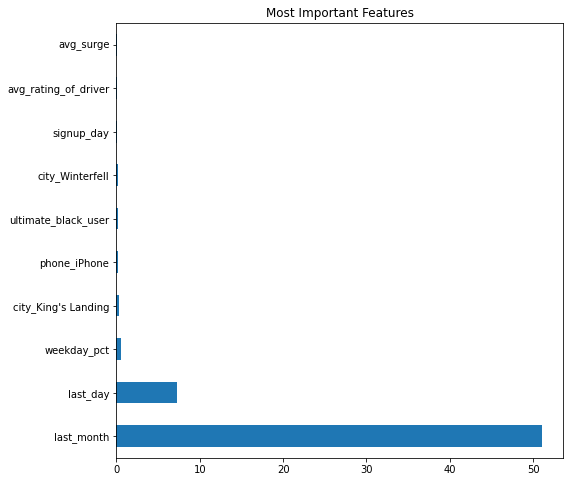

In [73]:
## Find most important features for Support Vector Classifier with previous 
## Grid Search best params.

features = X.columns
svm = SVC(kernel='linear', C=20, gamma='scale')
svm.fit(X_train_scaled, y_train)

pd.Series(abs(svm.coef_[0]), index=features).nlargest(10).plot(kind='barh', figsize = (8,8), title='Most Important Features')

#Conclusion and findings
As you can see in the above code our baseline model reached a level of 63% accuracy with an F1 score of .33. I chose to use a SVM model because it works great with big datasets and classification. Our support vector classifier achieved an accuracy of 99% with an F1 score of .99. The best parameters for our SVM classifier were selected using GridSearchCV. After viewing the confusion matrix for our SVM classifier we can see that it incorrectly misclassified a select few datapoints on both ends. 

In the chart above we can see that the most contributing features to our alogrithm were 'last_month', 'last_day', and 'weekday_pct'. 

Ultimate will be able to leverage the new insights provided by my model. With these insights they can target customers with similar characterics as those in the 'non_retained' group and figure out ways to better serve their needs. Therefore, with the use of my model, Ultimate will be able to increase their user retention rate. 